# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка библиотек и первичный взгляд на данные

In [48]:
#импортируем необходимые библиотеки и модули
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from scipy.stats import mode


In [49]:
#загрузим данные
data = pd.read_csv('/datasets/autos.csv')
#посмотрим общую информацию о данных
print('Общая информация о данных:')
print(data.info(verbose = False, show_counts = False))
print()
#посмотрим количество пропусков
display('Количество пропусков:', pd.DataFrame(data.isna().sum()).sort_values(by = 0, ascending = False))

#выведем 5 строк таблицы
data.sample(5)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Columns: 16 entries, DateCrawled to LastSeen
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None



'Количество пропусков:'

,0
NotRepaired,71154
VehicleType,37490
FuelType,32895
Gearbox,19833
Model,19705
DateCrawled,0
Price,0
RegistrationYear,0
Power,0
Kilometer,0


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
218047,2016-04-03 19:42:28,0,small,2000,manual,60,other,150000,1,petrol,peugeot,yes,2016-04-03 00:00:00,0,66386,2016-04-05 20:15:57
150237,2016-03-25 18:52:21,1000,wagon,1997,manual,85,vectra,150000,11,petrol,opel,no,2016-03-25 00:00:00,0,98708,2016-04-07 00:46:07
132624,2016-03-27 10:36:24,5200,bus,2010,manual,73,other,90000,6,petrol,peugeot,no,2016-03-27 00:00:00,0,26419,2016-03-30 14:46:38
16266,2016-03-07 16:54:44,2999,sedan,1999,manual,103,other,125000,9,petrol,fiat,no,2016-03-07 00:00:00,0,78464,2016-03-28 00:16:46
345835,2016-03-08 22:58:21,690,small,1999,manual,86,other,150000,3,petrol,suzuki,no,2016-03-08 00:00:00,0,41516,2016-03-12 10:44:45


<b>Промежуточный вывод:</b> имеем 354369 объектов и 16 признаков, включая ЦП (цена). 7 из них включая ЦП - количественные, остальные - категориальные. В 5 категориальных фичах довольно много пропусков, которые желательно было бы заполнить. Но прежде чем приступить к этому нужно проверить численные данные на предмет аномалий.

### Проверка численных данных на аномалии

In [50]:
#сохраним нужные фичи в numeric_data
numeric_data = data.drop(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'],
                         axis = 1)

#отобразим х-ки мер центральной тенденции и разброса
display(numeric_data.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<b>Промежуточный вывод:</b>
Замечены аномалии следующего рода:
- нули в минимальной цене - исходим из предположения, что этого быть не может, т.к. даже самый битый и старый автомобиль сколько-то да стоит
- минимальный и максимальный годы регистрации не могут быть датированы как 1000 и 9999. Вероятно, произошла ошибка при вводе данных со стороны пользователя
- минимальная мощность в Л.С. не может быть нулевой, а максимальный показатель явно не может быть 20000
- месяц регистрации авто также не может быть нулевым, диапазон от 1 до 12

Попытаемся исправить аномалии

### Исправление аномалий в численных данных

Верхняя граница года регистрации для 1% авто равна: 1980.0
Верхняя граница года регистрации для 99% авто равна: 2018.0


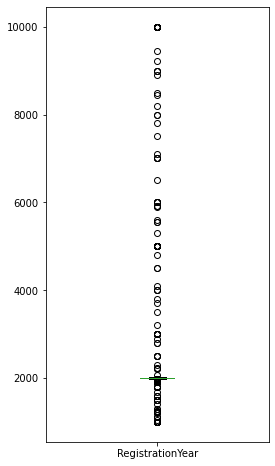

In [51]:
#посмотрим на аномалии в годах регистрации
data['RegistrationYear'].plot(kind = 'box', figsize = (4,8))
#выделим квантили по показателям года регистрации
print('Верхняя граница года регистрации для 1% авто равна:', data['RegistrationYear'].quantile(0.01))
print('Верхняя граница года регистрации для 99% авто равна:', data['RegistrationYear'].quantile(0.99))

<b>Промежуточный вывод:</b> аномалий довольно много. Оставим актуальный период.

348035


<AxesSubplot:title={'center':'Актуальный размах лет регистрации авто'}>

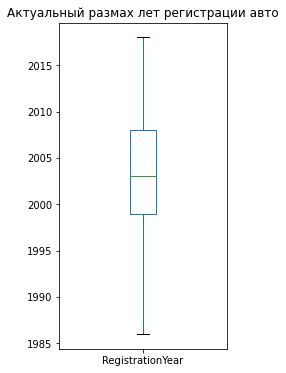

In [52]:
#отберем машины с аномальными годами регистрации
#и унифицируем аномальные года
for value in data['RegistrationYear']:
    if value > 2018 or value < 1986: 
         data['RegistrationYear'].replace(value, np.nan, inplace = True)
data.dropna(axis = 0, how = 'any', subset = ['RegistrationYear'], inplace = True)
print(len(data))

#еще раз взглянем на разброс лет
data['RegistrationYear'].plot(kind = 'box', figsize = (3,6), title = 'Актуальный размах лет регистрации авто')

<b>Вывод:</b> все стало выглядеть приличнее. Везде диапазон в приемлемых границах, а все аномалии удалены

Посмотрим на аномалии в месяцах. Строго говоря, едва ли на цену машины будет сильно влиять месяц регистрации, да и восстановить его не представляется возможным. Поэтому можно либо оставить нули, либо заполнить пропуски с помощью значения моды, т.е. наиболее частотного. Для начала посмотрим на распределение месяцев

<AxesSubplot:title={'center':'Распределение частотности месяцев регистрации авто'}, ylabel='RegistrationMonth'>

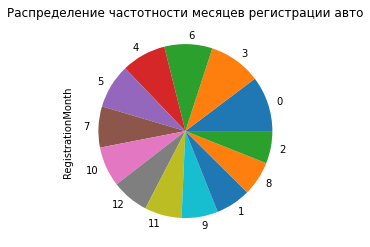

In [53]:
#взглянем на распределение по месяцам
plt.title('Распределение частотности месяцев регистрации авто')
data['RegistrationMonth'].value_counts().plot(kind = 'pie')

<b>Вывод:</b> нули явно лидируют по количеству, остальные месяцы встречаются более-менее в равных долях. Оставим нули как маркер того, что пользователь не помнит точно, в какой месяц была произведена регистрация.



Пришло время посмотреть на аномалии в ЛС. Здесь не обойтись без предварительного research: максимальное кол-во ЛС авто 4000 (фиксированный мировой рекорд у грузовика, предназначенного для перевозки супертяжелых грузов). Самые мощные спорткары достигают потолка в 600-700 ЛС (Tesla). Возьмем показатель 700 за потолок мощности. Минимальный порог с учетом, что мы оставили возможности продажи автомобилий категории "ретро", поставим 30 лс

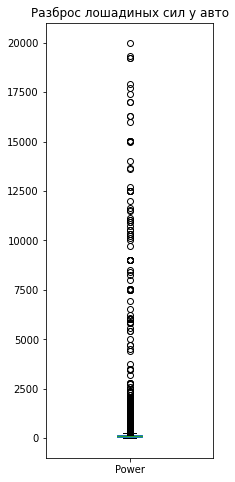

Верхняя граница ЛС 99% авто: 300.0
Верхняя граница ЛС 1% авто: 0.0
Количество аномально больших значений ЛС: 3834
Количество аномально маленьких значений ЛС: 40321


<AxesSubplot:title={'center':'Разброс лошадиных сил у авто после замены аномалий'}>

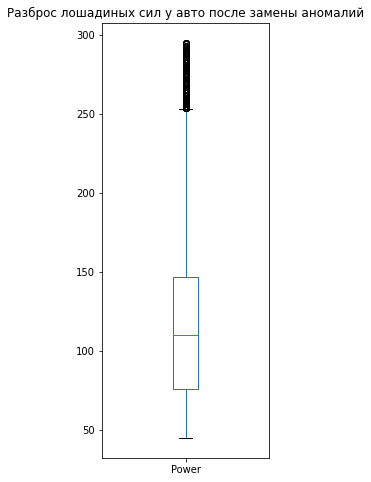

In [54]:
#взглянем на разброс значений ЛС
plt.title('Разброс лошадиных сил у авто')
data['Power'].plot(kind = 'box', figsize = (3,8))
plt.show()

#посмотрим на квантили
print('Верхняя граница ЛС 99% авто:', data['Power'].quantile(0.99))
print('Верхняя граница ЛС 1% авто:', data['Power'].quantile(0.01))

#посчитаем число аномалий
print('Количество аномально больших значений ЛС:', data.query('Power > 295')['Power'].count())
print('Количество аномально маленьких значений ЛС:', data.query('Power < 45')['Power'].count())

#заменим аномально большие значения на nan
for value in data['Power']:
    if value > 295 or value < 45:
        data['Power'].replace(value, np.nan, inplace = True)
        
#удалим аномальные значения, тк их немного
data.dropna(axis = 0, how = 'any', subset = ['Power'], inplace = True)

#посмотрим еще раз на разброс значений
plt.title('Разброс лошадиных сил у авто после замены аномалий')
data['Power'].plot(kind = 'box', figsize = (3,8))

<b>Вывод:</b> с ЛС разобрались. Осталось поправить аномалии в цене. Для начала оценим количество пропусков и посмотрим на корреляцию цены с другими количественными переменными. Скорее всего, придется заполнять пропуски в ценах на основании категориальных фич - модели и бренда.

In [55]:
#посмотрим на нули в цене авто
print('Количество авто с нулевой стоимостью:', data[data['Price'] == 0]['Price'].count())

#посмотрим на корреляцию колич. данных
numeric_data.corr()

Количество авто с нулевой стоимостью: 6533


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


<b>Промежуточный вывод:</b> гипотеза подтвердилась, на основании одних только количественных данных аномальные цены не поменять. Придется сначала разобраться с пропусками в категориальных переменных.

<b>ПОМЕТКА</b> ЦП не поправлен, необходимо проработать аномалии на следующих шагах

### Заполнение пропусков в категориальных переменных

Напомним, что пропуски в столбцах VehicleType, Gearbox, Model, FuelType и NotRepaired

Логика заполнения следующая: каждая модель имет свой срок жизни и, соответственно, год выпуска. В зависимости от модели определяется тип авто, коробки передач и используемое топливо. Следовательно, для заполнения два ключевых признака - год регистрации авто и его модель. Модель заполняем по категориям бренда и года регистрации, благо там нет пропусков. 
NotRepaired заполнить проще всего - была машина в ремонте или нет. Пропуски трактуем как "нет" - если не была, можно и не указывать. 

In [56]:
#создадим ф-цию для заполнения модели в зависимости от бренда и года
data['Model'] = data.groupby(['Brand','RegistrationYear'])['Model'].transform(lambda x: x.fillna((x.mode()[0]
                                                                                if not x.mode().empty else "other")))

#создадим ф-цию для заполнения типа ТС, топлива и коробки передач в зависимости от модели и года
columns = ['VehicleType', 'Gearbox', 'FuelType']
for column in columns:
    data[column] = data.groupby(['Model','RegistrationYear'])[column].transform(lambda x: x.fillna((x.mode()[0]
                                                                                if not x.mode().empty else "Unknown")))

#разберемся с пропусками в NotRepaired и заменим ответы на 0 и 1
data['NotRepaired'].fillna(0, inplace = True)
data['NotRepaired'].replace({'yes': 1, 'no' : 0}, inplace = True)
data['NotRepaired'] = data['NotRepaired'].astype('int64')

#проверим пропуски по всему датасету
display('Пропусков после заполнения:', pd.DataFrame(data.isna().sum()))

'Пропусков после заполнения:'

,0
DateCrawled,0
Price,0
VehicleType,0
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0


<b>Вывод:</b> пропусков в категориальных переменных не осталось, теперь осталось разобраться с аномальными ценами


In [57]:
#заменим нули на медианное значение цены в зависимости от модели и пробега
data['Price'] = data.groupby(['Model','Kilometer'])['Price'].transform(lambda x:
                                                                       x.replace((0, x.median())))
#проверим нулевые значения после заполнения
print('Нулевых цен после заполнения:', data[data['Price'] ==0]['Price'].count())

Нулевых цен после заполнения: 61


<b>Вывод:</b> осталось 60 нулевых цен, очевидно, это авто, по которым никак нельзя восстановить хотя бы приблизительную стоимость. Т.к. на фоне 300000 наблюдений это немного, удалим эти данные, а также приступим к разделению на тренировочную и тестовую выборки.

### Подготовка выборок, разделение данных на ЦП и features

In [58]:
#удалим оставшиеся аномальные цены
data['Price'] = data['Price'].replace(0, np.nan)
data.dropna(subset = ['Price'], inplace = True)

In [59]:
#сохраним копию датасета в data_categorical (т.к CatBoost и LGB не допускают предварит. кодирования)
data_categorial = data.copy()

In [60]:
#закодируем категориальные фичи с помощью OHE
categorial_features = ['Brand','Model','VehicleType','Gearbox','FuelType']
data = pd.get_dummies(data, columns=categorial_features, drop_first = True)
#проверим данные после кодирования
data.sample(3)

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,DateCreated,NumberOfPictures,PostalCode,...,VehicleType_wagon,Gearbox_auto,Gearbox_manual,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol
170268,2016-03-11 15:51:16,550.0,1995.0,75.0,125000,3,0,2016-03-11 00:00:00,0,19386,...,0,0,1,0,0,0,0,0,0,1
175017,2016-03-08 20:56:31,2000.0,2005.0,58.0,100000,6,0,2016-03-08 00:00:00,0,30880,...,0,0,1,0,0,0,0,0,0,1
222160,2016-04-03 19:52:58,5499.0,2006.0,250.0,60000,2,0,2016-04-03 00:00:00,0,57078,...,1,1,0,0,0,0,0,0,0,1


In [61]:
#масштабируем колич. фичи 
scaler = StandardScaler()
numeric_columns = ['RegistrationYear','Power','Kilometer']
scaler.fit(data[numeric_columns])
data[numeric_columns] = scaler.transform(data[numeric_columns])

#проверим данные
data.sample(3)

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,DateCreated,NumberOfPictures,PostalCode,...,VehicleType_wagon,Gearbox_auto,Gearbox_manual,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol
334194,2016-03-29 16:55:46,3000.0,-0.103922,0.345943,0.579080,4,0,2016-03-29 00:00:00,0,10969,...,0,1,0,0,0,0,0,0,0,1
331644,2016-03-14 21:47:43,199.0,1.995768,-1.535210,0.579080,0,1,2016-03-14 00:00:00,0,1609,...,0,0,1,0,0,0,0,0,0,1
278766,2016-03-16 11:57:05,10999.0,0.703651,-0.051189,-1.348028,5,0,2016-03-16 00:00:00,0,45478,...,0,0,1,0,0,0,0,0,0,1


In [62]:
#выделим ЦП и нужные features для линейной регрессии
data_target = data['Price']
data_features = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'Price'], axis = 1)

#проверим размерность ЦП и фич
print(data_target.shape)
print(data_features.shape)

#разобьем данные на обучающую и тестовую выборки для Линейной Регрессии
x_train, x_test, y_train, y_test = train_test_split(data_features, data_target, test_size = 0.25,
                                                   random_state = 42)

#проверим размерность выборок
print('Обучающая выборка для линейной регрессии:', len(x_train), len(y_train))
print('Тестовая выборка для линейной регрессии:', len(x_test), len(y_test))

(303819,)
(303819, 307)
Обучающая выборка для линейной регрессии: 227864 227864
Тестовая выборка для линейной регрессии: 75955 75955


In [63]:
#подготовим выборки для LGB и CatBoost
categorial_features = ['Brand','Model','VehicleType','Gearbox','FuelType']
#объявим категориальные фичи категориальными
data_categorial[categorial_features] = data_categorial[categorial_features].astype('category')
#отделим фичи от ЦП
data_target_cat = data_categorial['Price']
data_features_cat = data_categorial.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'Price'], axis = 1)
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(data_features_cat,
                                                                    data_target_cat, test_size = 0.25,
                                                   random_state = 42)
#проверим размерность выборок
print('Обучающая выборка для CatBoost и LGBM:', len(x_train_cat), len(y_train_cat))
print('Тестовая выборка для CatBoost и LGBM:', len(x_test_cat), len(y_test_cat))

Обучающая выборка для CatBoost и LGBM: 227864 227864
Тестовая выборка для CatBoost и LGBM: 75955 75955


<b>ВЫВОД ПО ЭТАПУ</b> данные загружены, очищены и подготовлены. Нужные выборки получены. Можно приступать к обучению моделей

## Обучение моделей

### Проверка показателей DummyRegressor

Поскольку перед нами стоит задача регрессии и цель - минимизировать функцию потерь, прежде всего необходимо посмотреть, насколько хорошо с задачей справляется случайная модель и сколько времени занимает ее работа

In [64]:
#создадим списки для сохранения результатов работы алгоритмов
algorithms = ['Dummy Regressor', 'Linear Regression', 'CatBoost', 'CatBoost Tuned', 'LGBM', 'LGBM Tuned']
results = []
education_time = []
prediction_time = []

In [65]:
#засечет время обучения и обучим модель
start = time.time()
model_dummy = DummyRegressor()
model_dummy.fit(x_train, y_train)
#остановим таймер и зафиксируем результаты
end = time.time()
dummy_education_time = end - start
education_time.append(dummy_education_time)

#засечем время получения предсказаний
start = time.time()
predictions = model_dummy.predict(x_test)
#остановим таймер и зафиксируем результаты
end = time.time()
dummy_prediction_time = end - start
prediction_time.append(dummy_prediction_time)

result = mean_squared_error(predictions, y_test)
print('RMSE случайной модели составляет:', result**0.5)

results.append(result**0.5)

RMSE случайной модели составляет: 4492.035767750389


<b>Вывод:</b> случайная модель ошибается на 4500 евро. Посмотрим, как покажут себя остальные модели. Начнем с линейной регрессии

### Проверка работы линейной регрессии 

In [66]:
#объявим модель
model_lr = LinearRegression()

#засечем время обучения и обучим модель
start = time.time()
model_lr.fit(x_train, y_train)
#остановим таймер
end = time.time()
#добавим рез-ты в список
lr_education_time = end - start
education_time.append(lr_education_time)

#засечем время предсказания и получим ответы
start = time.time()
predictions = model_lr.predict(x_test)
end = time.time()
lr_prediction_time = end - start
prediction_time.append(lr_prediction_time)

#рассчитаем RMSE и добавим рез-т в список
result = mean_squared_error(predictions, y_test)
results.append(result**0.5)
print('RMSE линейной регрессии составляет:', result**0.5)

RMSE линейной регрессии составляет: 2499.607830458686


<b>Вывод:</b> линейная регрессия ошибается на 2500 евро. Особо ее не оттюнингуешь. Посмотрим, как покажут себя остальные модели. 

### Проверка алгоритма CatBoost с тюнингом и без

In [67]:
%time
#объявим модель
cbr = CatBoostRegressor(random_state = 42, loss_function = 'RMSE',
                          cat_features = categorial_features, verbose = 200)
#засечем время и обучим CatBoost
start = time.time()
cbr.fit(x_train_cat, y_train_cat)
#остановим таймер и зафиксируем результат
end = time.time()
сatboost_education_time = end - start
education_time.append(сatboost_education_time)

#засечем время предсказания и получим ответы
start = time.time()
predictions = cbr.predict(x_test_cat)
end = time.time()
catboost_prediction_time = end - start
prediction_time.append(catboost_prediction_time)

#рассчитаем RMSE и добавим рез-т в список
result = mean_squared_error(predictions, y_test_cat)
results.append(result**0.5)
print('RMSE CatBoost составляет:', result**0.5)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs
Learning rate set to 0.096537
0:	learn: 4252.3623605	total: 341ms	remaining: 5m 40s
200:	learn: 1742.4266315	total: 41.1s	remaining: 2m 43s
400:	learn: 1686.3581243	total: 1m 20s	remaining: 1m 59s
600:	learn: 1657.8681467	total: 1m 59s	remaining: 1m 19s
800:	learn: 1637.7216107	total: 2m 38s	remaining: 39.4s
999:	learn: 1621.3186047	total: 3m 15s	remaining: 0us
RMSE CatBoost составляет: 1684.3429345432016


In [68]:
%%time
#добавим тюнинг гиперпараметров для модели и оценим результат
params = {'learning_rate': (0.4, 0.6, 0.8), 
          'iterations': [50, 100], 'depth': [4, 6, 8]}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=3,
                        scoring='neg_root_mean_squared_error',
                        verbose=100)
#grid_cbr.fit(x_train_cat, y_train_cat)
#print(grid_cbr.best_params_)
#print(grid_cbr.best_score_)

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 41.5 µs


<b>Промежуточный результат:</b> после 12 минут поиска оптимальных гиперпараметров, наилучший показатель - ошибка в 1736 евро на тренировочной выборке при глубине 8, learning_rate 0.4 и числе итераций 100. CatBoost без тюнинга показал наилучший результат 1684 на тестовой выборке.

Увеличим число итераций до 500 при сохранении остальных гиперпараметров и оценим результат оттюнингованного CatBoost на тестовой выборке

In [69]:
%time
#объявим наилучшую модель CatBoost
best_cbr = CatBoostRegressor(random_state = 42, loss_function = 'RMSE',
                          cat_features = categorial_features, verbose = 200, depth = 8,
                            iterations = 500, learning_rate = 0.4)
#засечем время и обучим CatBoost
start = time.time()
best_cbr.fit(x_train_cat, y_train_cat)
#остановим таймер и зафиксируем результат
end = time.time()
best_сatboost_education_time = end - start
education_time.append(best_сatboost_education_time)

#засечем время предсказания и получим ответы
start = time.time()
predictions = best_cbr.predict(x_test_cat)
end = time.time()
best_catboost_prediction_time = end - start
prediction_time.append(best_catboost_prediction_time)

#рассчитаем RMSE и добавим рез-т в список
result = mean_squared_error(predictions, y_test_cat)
results.append(result**0.5)
print('RMSE лучшей модели CatBoost составляет:', result**0.5)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
0:	learn: 3362.6422433	total: 391ms	remaining: 3m 15s
200:	learn: 1558.6662595	total: 52.9s	remaining: 1m 18s
400:	learn: 1485.6247479	total: 1m 44s	remaining: 25.9s
499:	learn: 1459.6117445	total: 2m 11s	remaining: 0us
RMSE лучшей модели CatBoost составляет: 1652.1776063424688


После тюнинга лучшая модель CatBoost показала результат RMSE 1652

### Проверка работы алгоритма LGBM с тюнингом и без

In [70]:
%time
#объявим модель LGBM без тюнинга гиперпараметров
lgb = LGBMRegressor(random_state = 42, verbose = 0, force_row_wise= True)
#засечем время и обучим CatBoost
start = time.time()
lgb.fit(x_train_cat, y_train_cat)
#остановим таймер и зафиксируем результат
end = time.time()
lgb_education_time = end - start
education_time.append(lgb_education_time)

#засечем время предсказания и получим ответы
start = time.time()
predictions = lgb.predict(x_test_cat)
end = time.time()
lgb_prediction_time = end - start
prediction_time.append(lgb_prediction_time)

#рассчитаем RMSE и добавим рез-т в список
result = mean_squared_error(predictions, y_test_cat)
results.append(result**0.5)
print('RMSE LGBM без подбора гиперпараметров составляет:', result**0.5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
RMSE LGBM без подбора гиперпараметров составляет: 1706.4091309239357


In [71]:
#добавим тюнинг гиперпараметров для LGBM и оценим результат
lgb = LGBMRegressor(random_state = 42, force_row_wise = True, verbose = 500)
params = {'learning_rate': (0.2, 0.4, 0.5),
          'num_leaves': [21, 31, 41]}

grid_lgb = GridSearchCV(lgb,
                        param_grid =params,
                        cv=3,
                        scoring='neg_root_mean_squared_error')

#grid_lgb.fit(x_train_cat, y_train_cat)
#print(grid_lgb.best_params_)
#print(grid_lgb.best_score_)

<b>Промежуточный результат:</b> лучшие гиперпараметры для LGBM: 
- 'learning_rate': 0.2, 
- n_estimators': 80,
- num_leaves: 41

Лучший результат LGBM с подбором гиперпараметров на тренировочной выборке: -1857.7635467958155

Теперь проверим лучшую модель LGBM на тестовой выборке

In [72]:
%time
#объявим наилучшую модель LGBM
best_lgb = LGBMRegressor(random_state = 42, verbose = 0,
                         force_row_wise= True, learning_rate = 0.2, n_estimators = 80, num_leaves = 41)

#засечем время и обучим лучшую модель LGBM
start = time.time()
best_lgb.fit(x_train_cat, y_train_cat)
#остановим таймер и зафиксируем результат
end = time.time()
best_lgb_education_time = end - start
education_time.append(best_lgb_education_time)

#засечем время предсказания и получим ответы
start = time.time()
predictions = best_lgb.predict(x_test_cat)
end = time.time()
best_lgb_prediction_time = end - start
prediction_time.append(best_lgb_prediction_time)

#рассчитаем RMSE и добавим рез-т в список
result = mean_squared_error(predictions, y_test_cat)
results.append(result**0.5)
print('RMSE лучшей модели LGBM составляет:', result**0.5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
RMSE лучшей модели LGBM составляет: 1674.708693972845


С учетом гиперпараметров RMSE составила 1674 евро

## Анализ моделей

In [73]:
#соберем все показатели в сводную таблицу
#print(results, education_time, prediction_time)
model_estimation = pd.DataFrame(index = ['RMSE модели', 
                                         'Время обучения модели', 'Время предсказания модели'], 
             columns = algorithms)

model_estimation.iloc[0] = results
model_estimation.iloc[1] = education_time
model_estimation.iloc[2] = prediction_time

display(model_estimation)

,Dummy Regressor,Linear Regression,CatBoost,CatBoost Tuned,LGBM,LGBM Tuned
RMSE модели,4492.035768,2499.60783,1684.342935,1652.177606,1706.409131,1674.708694
Время обучения модели,0.000915,28.18243,197.688782,133.408697,5.589505,4.803764
Время предсказания модели,0.000343,0.19933,0.425963,0.436388,0.812356,0.601063


<b>Итоговый вывод</b> лидером по скорости как обучения, так и предсказания, является линейная регрессия, увы, ее качество оставляет желать лучшего. Наилучший результат показала модель CatBoost после подбора гиперпараметров - RMSE составляет 1652 евро. К тому же, ее скорость обучения выше, чем у LGBM. LGBM после подбора гиперпараметров занимает последнее место по скорости при довольно неплохом результате (однако поиск параметров по сетке был очень долгим). 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей